In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import PyTorch_mlp_cali_y_kannsuu as torch_mlp

import numpy as np
import DataSetting
import DataSetting_Cali
np.set_printoptions(threshold=np.inf)

In [2]:
M = 1

In [17]:
dir_C = "../CalibrationData/Cali_Co"
file_Cali = "/Data"

data = DataSetting_Cali.re_Cali_velo(dir_C, file_Cali, 1, M, 3)


In [18]:
data.send_y_array[:, 0, 0]

array([-2.64689128e-02,  1.56697591e-01,  6.99666341e-02,  2.66927083e-01,
        2.50264486e-01,  4.56746419e-01,  7.30855306e-01,  9.51009115e-01,
        1.00453695e+00,  1.09193929e+00,  9.44844564e-01,  8.83321126e-01,
        9.01509603e-01,  7.56001790e-01,  7.00948079e-01,  5.44453939e-01,
        4.34590658e-01,  4.04134115e-01,  3.08797201e-01,  1.87703451e-01,
        1.37837728e-01,  5.57454427e-03, -9.61710612e-02, -2.46683757e-01,
       -3.11686198e-01, -2.50712077e-01, -2.88859049e-01, -2.48636882e-01,
       -1.45182292e-01, -1.50492350e-01, -6.13199870e-02,  1.54988607e-01,
        2.93233236e-01,  3.87288411e-01,  5.52327474e-01,  7.66621908e-01,
        9.86714681e-01,  1.11104329e+00,  1.24873861e+00,  1.43025716e+00,
        1.46761068e+00,  1.57393392e+00,  1.54872640e+00,  1.56490072e+00,
        1.48549398e+00,  1.38112386e+00,  1.26137288e+00,  1.23140462e+00,
        1.22829183e+00,  1.21455892e+00,  1.20198568e+00,  1.25423177e+00,
        1.31868490e+00,  

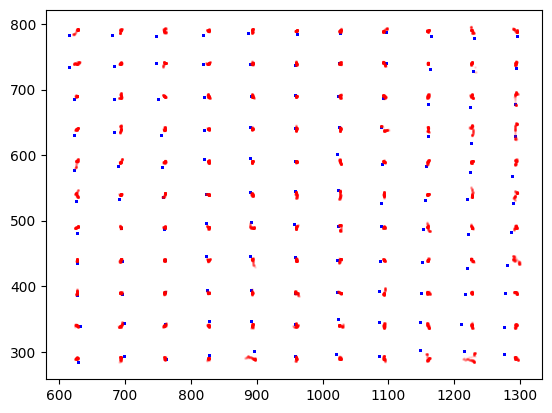

In [19]:
plt.figure()
x = data.send_x_array[:, 0, 0]
y = data.send_x_array[:, 1, 0]
plt.scatter(x, y, s = 1, c = "b")

x = data.send_x_array[:, 0, 0] - data.send_y_array[:, 0, 0] 
y = data.send_x_array[:, 1, 0] - data.send_y_array[:, 1, 0] 
plt.scatter(x, y, s = 1, c = "r", alpha=0.1)

# x = s_x_false[:, 0, 0] - s_y_false[:, 0, 0] 
# y = s_x_false[:, 1, 0] - s_y_false[:, 1, 0] 
# plt.scatter(x, y, s = 1, c = "r", alpha=0.01)
# plt.xlim(960 - 10, 960 + 10)
# plt.ylim(540 - 10, 540 + 10)

In [20]:
print(x)

[ 628.17231669  627.98915019  628.07588114  627.87892069  627.89558329
  627.68910136  627.41499247  627.19483866  627.14131083  627.05390849
  627.20100321  627.26252665  627.24433818  627.38984599  627.4448997
  627.60139384  627.71125712  627.74171366  627.83705058  627.95814433
  628.00801005  628.14027323  628.24201884  628.39253153  628.45753398
  628.39655986  628.43470683  628.39448466  628.29103007  628.29634013
  628.20716777  627.99085917  627.85261454  627.75855937  627.5935203
  627.37922587  627.1591331   627.03480448  626.89710917  626.71559062
  626.6782371   626.57191386  626.59712138  626.58094706  626.6603538
  626.76472392  626.88447489  626.91444316  626.91755595  626.93128886
  626.9438621   626.89161601  626.82716288  626.81507792  626.79078593
  626.72981181  626.71327128  626.75526347  626.7349998   626.67787089
  626.60981669  626.5063621   626.49708476  626.41645732  626.21369853
  626.06697001  626.03034892  626.02033915  626.04170146  626.05384745
  626.017

In [21]:
x1 = np.hstack([data.send_x_array[:, 0:1, 0].copy(), data.send_x_array[:, 1:2, 0].copy()])

In [22]:
y1 = np.hstack([data.send_y_array[:, 0:1, 0].copy(), data.send_y_array[:, 1:2, 0].copy()])

In [23]:
xx1= torch.from_numpy(x1.copy()).float()
yy1 = torch.from_numpy(y1.copy()).float()

print(xx1.shape) 
print(yy1.shape)


Dataset = torch.utils.data.TensorDataset(xx1, yy1) 
train_size = int(len(Dataset) * 0.8) 
test_size = int(len(Dataset) * 0.01) 
valid_size = int(len(Dataset)) - train_size - test_size

train, test, valid = torch.utils.data.random_split(Dataset, [train_size, test_size, valid_size])

batch_size = 500
train_l = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = True) 
test_l = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle = True) 
valid_l = torch.utils.data.DataLoader(dataset = valid, batch_size = batch_size, shuffle = True)

torch.Size([11979, 2])
torch.Size([11979, 2])


In [24]:
class net_class (nn.Module):
    
    def __init__(self):
        super(net_class, self).__init__()
        
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        
        return x



In [25]:
torch.autograd.set_detect_anomaly(False)

net = net_class()



criterion_1 = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)



In [26]:
num_epochs = 100

t_loss, t_acc, v_loss, v_acc = torch_mlp.run(net, train_l, valid_l, criterion_1, optimizer, num_epochs, 1000)


epoch: 0 t_loss: 1.8307713597474908 v_loss: 0.5794086615453962


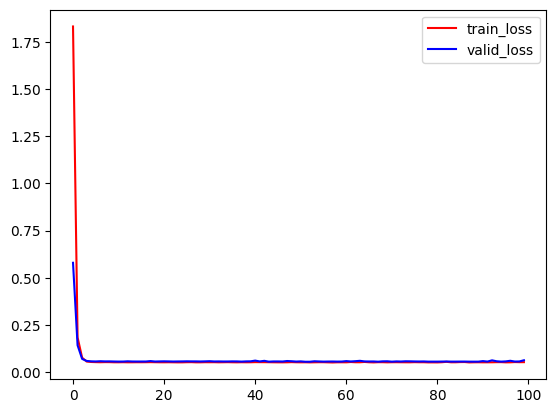

In [27]:
plt.figure()
plt.plot(range(num_epochs), t_loss, c = "r", label = "train_loss")
plt.plot(range(num_epochs), v_loss, c = "b", label = "valid_loss")
plt.legend()


In [28]:
y_ = net(torch.from_numpy(x1).float()).detach().numpy()


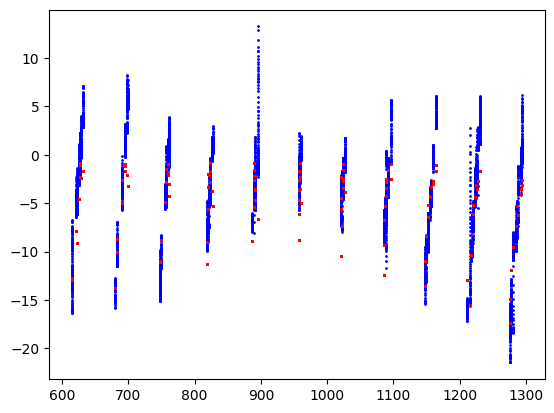

In [29]:
plt.figure()

x = x1[:, 0]
y = y1[:, 0]
plt.scatter(x, y, s = 1, c = "b")

x = x1[:, 0]
y = y_[:, 0]
plt.scatter(x, y, s = 1, c = "r")


In [ ]:
output_mlp = DataSetting.output_mlp()
mlp_data = DataSetting.mlp_data()
mlp_data.coef = net.fc1.weight.data.numpy().T.tolist()
mlp_data.intercept = net.fc1.bias.data.numpy().tolist()
output_mlp.hidden_layer.append(mlp_data)

mlp_data = DataSetting.mlp_data()
mlp_data.coef = net.fc2.weight.data.numpy().T.tolist()
mlp_data.intercept = net.fc2.bias.data.numpy().tolist()
output_mlp.hidden_layer.append(mlp_data)

mlp_data = DataSetting.mlp_data()
mlp_data.coef = net.fc3.weight.data.numpy().T.tolist()
mlp_data.intercept = net.fc3.bias.data.numpy().tolist()
output_mlp.hidden_layer.append(mlp_data)

output_mlp.of_from = 1
output_mlp.of_to = 1

dirPre = "../PyData"
filePre = "/py_cali_co"


name = dirPre + filePre
DataSetting.Pre_output(output_mlp, name)


In [ ]:
net.fc1.weight

Parameter containing:
tensor([[-6.5227e-01,  6.5686e-01],
        [-3.4469e-02,  1.5065e-01],
        [ 2.7061e-01, -3.5271e-01],
        [ 3.6542e-01,  3.9842e-02],
        [-5.3649e-02,  2.2605e-01],
        [-4.2648e-03, -9.7556e-04],
        [-5.9135e-01,  6.5440e-01],
        [ 1.8289e-02,  1.3655e-01],
        [ 5.9316e-02, -5.1853e-02],
        [-7.8037e-02,  2.6447e-01],
        [ 3.6507e-02, -3.6120e-02],
        [-2.8879e-07, -2.0990e-03],
        [-1.0472e-01,  4.3012e-01],
        [-7.2462e-21, -5.8968e-21],
        [-2.1576e-14, -1.7098e-33],
        [ 1.4691e-01,  1.2729e-01],
        [-7.3612e-01,  7.6692e-01],
        [-2.0890e-03,  9.9873e-04],
        [-5.4281e-17, -6.5790e-30],
        [-1.6258e-16, -4.7430e-31],
        [ 3.8720e-01, -2.0728e-01],
        [-4.2960e-02,  1.8260e-01],
        [ 3.5372e-01, -3.0171e-01],
        [ 1.6793e-02, -7.6190e-03],
        [ 4.7085e-01,  4.0434e-01],
        [-1.0843e-02, -3.0519e-03],
        [-2.4381e-03, -1.2652e-04],
      

In [ ]:
torch.save(net, "../PyData/pytorch_moto_model/py_cali_co_moto.pth")